In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

## Passo 1: Lendo os dados
Leitura dos bancos de dados em DataFrame Pandas. 

In [5]:
caminho_dados_lazaro = 'Datasets/Lazaro/dados_lazaro.csv'

In [6]:
df = pd.read_csv(caminho_dados_lazaro)

In [7]:
df

,Piquete,Altura real,Altura esperada,Animal,SensorID,Sensor Name,Date,X,Y,Z,Comportamento,Season
0,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 08:25:30,-0.012,-0.456,0.900,Indefinido,Indefinido
1,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 08:25:32,-0.008,-0.456,0.892,Indefinido,Indefinido
2,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 08:25:33,-0.010,-0.460,0.897,Indefinido,Indefinido
3,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 08:25:33,0.021,-0.386,0.963,Indefinido,Indefinido
4,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 08:25:34,0.012,-0.423,0.910,Indefinido,Indefinido
...,...,...,...,...,...,...,...,...,...,...,...,...
690561,1,10.3,10.0,81,434137,Accelerometer - 434137,2020-06-30 17:43:27,-0.729,0.026,0.660,Pastejando,fall
690562,1,10.3,10.0,81,434137,Accelerometer - 434137,2020-06-30 17:43:28,-0.614,0.271,0.577,Pastejando,fall
690563,1,10.3,10.0,81,434137,Accelerometer - 434137,2020-06-30 17:43:29,-0.734,0.227,0.571,Pastejando,fall
690564,1,10.3,10.0,81,434137,Accelerometer - 434137,2020-06-30 17:43:30,-0.587,-0.149,0.704,Pastejando,fall


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


def calc_acuracia(X_train, X_valid, y_train, y_valid):
    model = RandomForestClassifier(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return accuracy_score(y_valid, preds)*100

# Função para comparar diferentes aproximações
def avaliar_dataset(df):
    X = df[['X', 'Y', 'Z', 'Season']]
    # Para usar atributos categóricos na predição é necessário codificar os mesmos
    # O que pode ser feito usando get_dummies, que no caso tem resultado igual ao método One-Hot Encoding
    X = pd.get_dummies(X)
    y = df.Comportamento
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 0)

    print("Acurácio da etapa:")
    print(calc_acuracia(X_train, X_valid, y_train, y_valid))

## Passo 2: Pré-processamento


### 2.0 Seleção de colunas aplicáveis

In [9]:
df.columns

Index(['Piquete', 'Altura real', 'Altura esperada', 'Animal', 'SensorID',
       'Sensor Name', 'Date', 'X', 'Y', 'Z', 'Comportamento', 'Season'],
      dtype='object')

In [10]:
# Lista com os atributos aplicáveis
features_aplicaveis = ['X', 'Y', 'Z', 'Comportamento', 'Season']

# Seleciona os abributos correspondentes da lista features_aplicaveis
df = df[features_aplicaveis]

### 2.1 Lidando com dados faltantes

In [11]:
df[df.isnull().any(axis=1)]

,X,Y,Z,Comportamento,Season
296,175786.0,NaN,NaN,Indefinido,Indefinido


In [12]:
df.isnull().sum()

X                0
Y                1
Z                1
Comportamento    0
Season           0
dtype: int64

In [13]:
# No entanto, durante a integração dos dados valores nulos em "Comportamento" e "Season" foram nomeados "Indefinido", logo temos que tratá-los
df.Comportamento.value_counts()

Pastejando     342516
Ruminando      158228
Ocio           126141
Indefinido      23496
Outros          19472
Locomovendo     12567
Agua             3779
Outro            2303
Ócio             2064
Name: Comportamento, dtype: int64

In [14]:
df = df.replace('Indefinido', np.NaN)

In [15]:
# Como praticamente não há valores faltantes nas variáveis independentes e há obeservações com variáveis alvo nulas, o melhor é apenas eliminar linhas com valores nulos
df = df.dropna(axis=0)
df.isnull().sum()

X                0
Y                0
Z                0
Comportamento    0
Season           0
dtype: int64

In [16]:
df_backup = df

In [17]:
# avaliar_dataset(df)

Acurácio da etapa:
69.4935479228629


### 2.2 Tratamento de dados categóricos

#### Correção dos nomes das classificações

In [18]:
np.unique(df['Comportamento'])

array(['Agua', 'Locomovendo', 'Ocio', 'Outro', 'Outros', 'Pastejando',
       'Ruminando', 'Ócio'], dtype=object)

In [19]:
df = df.replace(to_replace=['Ócio','Outro'], value=['Ocio', 'Outros'])

In [20]:
np.unique(df['Season'])

array(['Spring', 'fall', 'spring', 'spring ', 'summer'], dtype=object)

In [21]:
df = df.replace(to_replace=['Spring','spring '], value=['spring', 'spring'])

In [22]:
X = df[['X', 'Y', 'Z', 'Season']]
# O que pode ser feito usando get_dummies, que no caso tem resultado igual ao método One-Hot Encoding
y = df.Comportamento
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 0)

#### Usando Ordinal Encoding

In [23]:
from sklearn.preprocessing import OrdinalEncoder

label_X_train = X_train.copy()
label_X_valid = X_valid.copy()

# Aplica ordinal encoder à coluna Season
ordinal_encoder = OrdinalEncoder()
label_X_train['Season'] = ordinal_encoder.fit_transform(X_train['Season'].values.reshape(-1,1))
label_X_valid['Season'] = ordinal_encoder.transform(X_valid['Season'].values.reshape(-1,1))

In [129]:
# calc_acuracia(label_X_train, label_X_valid, y_train, y_valid)

68.77578432313155

#### Usando One-Hot Encoding

In [24]:
from sklearn.preprocessing import OneHotEncoder

# Aplica one-hot encoder à coluna Season
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train['Season'].values.reshape(-1,1)))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid['Season'].values.reshape(-1,1)))

In [25]:
# One-hot encoding remove os indices; recuperando-os
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

In [26]:
# Remoção da coluna Season (será substituida com one-hot encoding)
num_X_train = X_train.drop('Season', axis=1)
num_X_valid = X_valid.drop('Season', axis=1)

In [27]:
# Adiciona colunas codificadas por one-hot a features numéricas
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

In [28]:
calc_acuracia(OH_X_train, OH_X_valid, y_train, y_valid)

68.94068406408903

In [59]:
# Get_dummies é suficente
# X = df[['X', 'Y', 'Z', 'Season']]
# X = pd.get_dummies(X)

In [108]:
# avaliar_dataset(df)

Acurácio da etapa:
68.94068406408903


### 2.3 Lidando com outliers

In [163]:
df.describe()

,X,Y,Z
count,667070.000000,667070.000000,667070.000000
mean,0.003695,0.076466,0.301583
std,0.576597,0.580242,0.496580
min,-1.999000,-2.688000,-1.999000
25%,-0.495000,-0.392000,-0.022000
50%,0.019000,0.136000,0.407000
75%,0.475000,0.541000,0.686000
max,2.106000,2.000000,2.020000


In [29]:
# Calculo de limites para definição de outliers
# Seleciona dados que estão e 1% e 99% do dados
min = 0.01
max = 0.99
X_min_thresold, X_max_thresold = df.X.quantile([min, max])
Y_min_thresold, Y_max_thresold = df.Y.quantile([min, max])
Z_min_thresold, Z_max_thresold = df.Z.quantile([min, max])


In [30]:
# Remoção de outliers em X
df = df[(df.X<X_max_thresold) & (df.X>X_min_thresold)]
df = df[(df.Y<Y_max_thresold) & (df.Y>Y_min_thresold)]
df = df[(df.Z<Z_max_thresold) & (df.Z>Z_min_thresold)]
df.shape


(629254, 5)

In [31]:
df.describe()

,X,Y,Z
count,629254.000000,629254.000000,629254.000000
mean,0.003006,0.076768,0.310776
std,0.562532,0.563549,0.473825
min,-1.007000,-0.996000,-0.928000
25%,-0.496000,-0.392000,-0.005000
50%,0.019000,0.144000,0.420000
75%,0.475000,0.541000,0.687000
max,1.000000,1.095000,1.072000


In [32]:
# Reseta os índices
df = df.reset_index(drop=True)

In [168]:
avaliar_dataset(df)

Acurácio da etapa:
68.94554839365854


## Passo 3: Treinamento

### Random Forest

In [36]:
X = df[['X', 'Y', 'Z', 'Season']]
X = pd.get_dummies(X)

y = df.Comportamento

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 0)

In [172]:
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train)
preds = model.predict(X_valid)

In [173]:
y_valid[10:20]

184873    Pastejando
549499    Pastejando
402603    Pastejando
199994     Ruminando
14157     Pastejando
189958    Pastejando
291377    Pastejando
539346    Pastejando
412844          Ocio
613529     Ruminando
Name: Comportamento, dtype: object

In [174]:
preds[10:20]

array(['Pastejando', 'Pastejando', 'Pastejando', 'Pastejando', 'Ocio',
       'Pastejando', 'Pastejando', 'Pastejando', 'Ruminando',
       'Pastejando'], dtype=object)

In [175]:
accuracy_score(y_valid, preds)*100

68.94554839365854

### Validação cruzada

In [181]:
from sklearn.model_selection import cross_val_score

def get_score(n_estimators):
    clf = RandomForestClassifier(n_estimators, random_state=0)
    
    scores = cross_val_score(clf, X, y, cv=3)
    return scores.mean()


In [182]:
results = {} 
n_estimators = 0
while n_estimators < 150:
    n_estimators += 50
    results[n_estimators] = get_score(n_estimators)

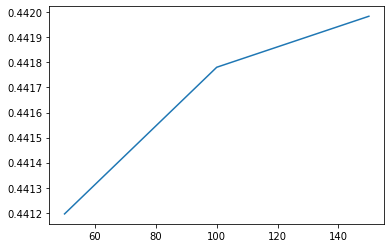

In [200]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

### Matriz de Confusão

In [185]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_valid, preds)

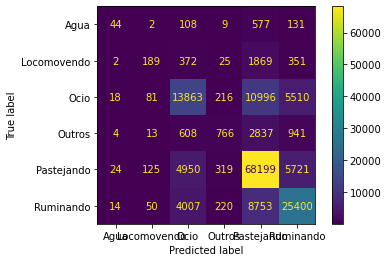

In [186]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

### Gradient Boosting

In [42]:
X = df[['X', 'Y', 'Z', 'Season']]
X = pd.get_dummies(X)
y = df.Comportamento

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 0)

In [43]:
from xgboost import XGBClassifier

xgb_cl = XGBClassifier()
xgb_cl.fit(X_train, y_train)

/home/caio/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:51:47] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [46]:
preds_2 = xgb_cl.predict(X_valid)

accuracy_score(y_valid, preds_2)

0.6503108432815897